## Imports

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from tqdm import tqdm

import ruptures as rpt
from utils.custom_cost import CostNew
from SKAB_data.evaluating import evaluating_change_point

%load_ext autoreload
%autoreload 2

In [75]:
from ensemble_methods.aggregations import SCALING_AGGREGATION_PAPER, SCALING_AGGREGATION_INVESTIGATION

SINGLE_COSTS = (
    {'name': 'ar_1', 'cost':'ar', 'params':{'order':1}},
    {'name': 'ar_5', 'cost':'ar', 'params':{'order':5}},
    {'name': 'mahalanobis', 'cost':'mahalanobis', 'params':{}},
    {'name': 'l1', 'cost':'l1', 'params':{}},
    {'name': 'l2', 'cost':'l2', 'params':{}},
    {'name': 'linear', 'cost':'linear', 'params':{}}
)

DESIRED_ORDER = ["Standart", "LowFP", "LowFN"]

## Load data

In [49]:
from sklearn.preprocessing import StandardScaler


# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk("SKAB_data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))


# datasets with anomalies loading
test = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True).drop('anomaly', axis=1) for file in all_files if 'anomaly-free' not in file]

# Save labels
true_cp = [dataset.changepoint for dataset in test]

# Standardise
for idx_data in range(len(test)):
    stsc = StandardScaler()
    test[idx_data] = pd.DataFrame(stsc.fit_transform(test[idx_data].drop("changepoint", axis=1)), columns=test[idx_data].columns.drop("changepoint"), index=test[idx_data].index)

## Visualize a signal

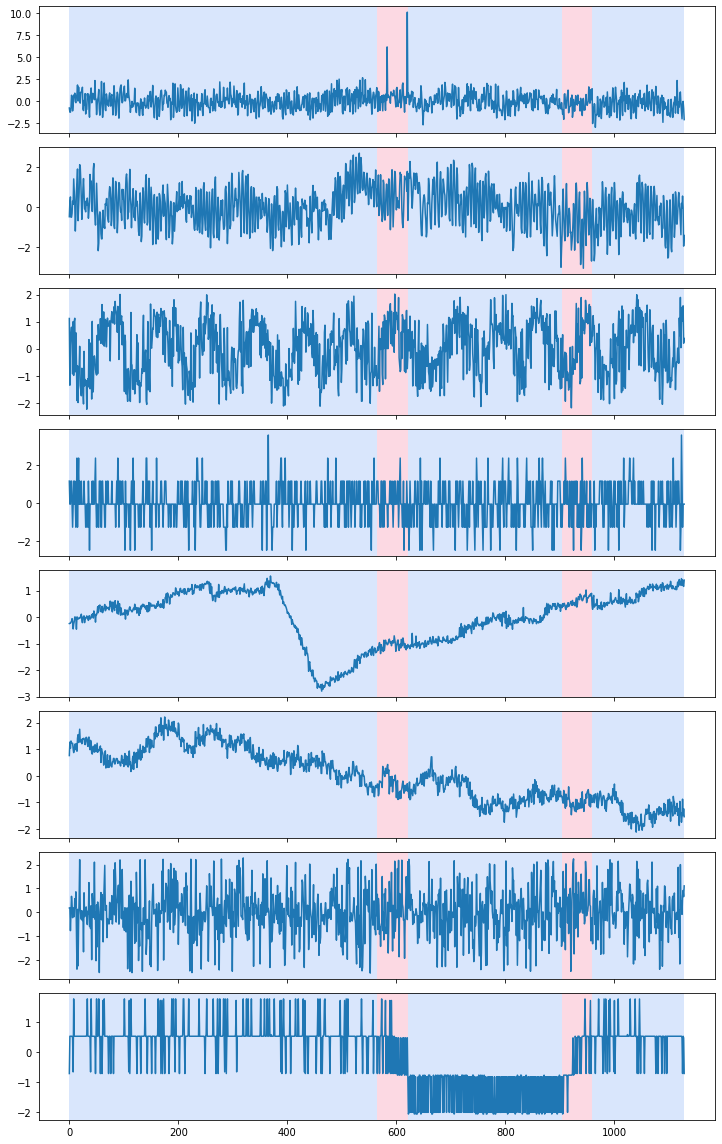

In [50]:
idx_signal = 15

break_points = list(np.nonzero(true_cp[idx_signal].values == 1)[0]) + [test[idx_signal].shape[0]]
_ = rpt.display(test[idx_signal].values, break_points)

## Window search

In [76]:
def window_search(cost, params, **kwargs):
    predicted_cp = []
    for idx_data in range(len(test)):
        algo = rpt.Window(model=cost, 
                          params=params, 
                          width=20,
                          jump=1)
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))
        
        single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)
        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

table_costs_window = {}
for cost in tqdm(SINGLE_COSTS):
        table_costs_window[cost["name"]] = window_search(**cost)

pd.DataFrame(table_costs_window).T[DESIRED_ORDER]

100%|██████████| 6/6 [00:58<00:00,  9.67s/it]


,Standart,LowFP,LowFN
ar_1,15.54,12.77,16.77
ar_5,12.36,9.58,13.62
mahalanobis,15.55,13.44,16.27
l1,18.40,16.22,19.19
l2,14.78,12.40,16.01
linear,12.69,9.72,14.10


In [ ]:
def window_search_ensemble_bound():
    predicted_cp = []
    for idx_data in tqdm(range(len(test))):
        best_nab_sum = - float("inf")
        best_single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)

        for model in SINGLE_COSTS:
            algo = rpt.Window(model=model["cost"], 
                            params=model["params"], 
                            width=20,
                            jump=1)
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))
            
            single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)
            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            
            nab_model = evaluating_change_point([true_cp[idx_data]], [single_predicted_cp], metric='nab', numenta_time='30 sec')
            
            if sum(list(nab_model.values())) > best_nab_sum:
                best_nab_sum = sum(list(nab_model.values()))
                best_single_predicted_cp = single_predicted_cp
                
        predicted_cp.append(best_single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

window_ensemble_bound = window_search_ensemble_bound()
pd.DataFrame(window_ensemble_bound, index=["Ensemble bound"])[DESIRED_ORDER]

In [77]:
from ensemble_methods.window_ensemble import WindowEnsemble

def window_search_ensemble(scale_aggregation):
    predicted_cp = []
    for idx_data in range(len(test)):
        algo = WindowEnsemble(custom_cost=CostNew(), 
                                    jump=1, 
                                    scale_aggregation=scale_aggregation, 
                                    width=20)
        single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)
        
        try:
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))

            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            predicted_cp.append(single_predicted_cp)
        except:
            predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

In [ ]:
table_ensemble_window = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION_PAPER.items()):
    table_ensemble_window[scale_aggregation_name] = window_search_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_window).T[DESIRED_ORDER]

In [ ]:
table_ensemble_window_investigation = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION_INVESTIGATION.items()):
    table_ensemble_window_investigation[scale_aggregation_name] = window_search_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_window_investigation).T[DESIRED_ORDER]

## Dynamic Programming

In [ ]:
def dynp_search(cost, params, **kwargs):
    predicted_cp = []
    for idx_data in range(len(test)):
        algo = rpt.Dynp(model=cost, 
                          params=params,
                          jump=1)
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))
        
        single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)
        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

table_costs_dynp = {}
for cost in tqdm(SINGLE_COSTS):
    table_costs_dynp[cost["name"]] = dynp_search(**cost)

pd.DataFrame(table_costs_dynp).T[DESIRED_ORDER]

In [ ]:
def dynp_search_ensemble_bound():
    predicted_cp = []
    for idx_data in tqdm(range(len(test))):
        best_nab_sum = - float("inf")
        best_single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)

        for model in SINGLE_COSTS:
            algo = rpt.Dynp(model=model["cost"], 
                          params=model["params"],
                          jump=1)
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))
            
            single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)
            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            
            nab_model = evaluating_change_point([true_cp[idx_data]], [single_predicted_cp], metric='nab', numenta_time='30 sec')
            
            if sum(list(nab_model.values())) > best_nab_sum:
                best_nab_sum = sum(list(nab_model.values()))
                best_single_predicted_cp = single_predicted_cp
                
        predicted_cp.append(best_single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

dynp_ensemble_bound = dynp_search_ensemble_bound()
pd.DataFrame(dynp_ensemble_bound, index=["Ensemble bound"])[DESIRED_ORDER]

In [78]:
from ensemble_methods.dynamic_programming_ensemble import DynpEnsemble

def dynamique_programming_ensemble(scale_aggregation):
    predicted_cp = []
    for idx_data in range(len(test)):
        algo = DynpEnsemble(custom_cost=CostNew(), 
                                    jump=1, 
                                    scale_aggregation=scale_aggregation
                                    )
        single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)
        
        try:
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))

            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            predicted_cp.append(single_predicted_cp)
        except:
            predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

In [ ]:
table_ensemble_dynp = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION_PAPER.items()):
    table_ensemble_dynp[scale_aggregation_name] = dynamique_programming_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_dynp).T[DESIRED_ORDER]

In [ ]:
table_ensemble_dynp_investigation = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION_INVESTIGATION.items()):
    table_ensemble_dynp_investigation[scale_aggregation_name] = dynamique_programming_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_dynp_investigation).T[DESIRED_ORDER]

## Binary Segmentation

In [ ]:
def binseg_search(cost, params, **kwargs):
    predicted_cp = []
    for idx_data in range(len(test)):
        algo = rpt.Binseg(model=cost, 
                          params=params,
                          jump=1)
        algo.fit(np.array(test[idx_data]))
        my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))
        
        single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)
        single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
        predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

table_costs_dynp = {}
for cost in tqdm(SINGLE_COSTS):
    table_costs_dynp[cost["name"]] = binseg_search(**cost)

pd.DataFrame(table_costs_dynp).T[DESIRED_ORDER]

In [ ]:
def binseg_search_ensemble_bound():
    predicted_cp = []
    for idx_data in tqdm(range(len(test))):
        best_nab_sum = - float("inf")
        best_single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)

        for model in SINGLE_COSTS:
            algo = rpt.Binseg(model=model["cost"], 
                          params=model["params"],
                          jump=1)
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))
            
            single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)
            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            
            nab_model = evaluating_change_point([true_cp[idx_data]], [single_predicted_cp], metric='nab', numenta_time='30 sec')
            
            if sum(list(nab_model.values())) > best_nab_sum:
                best_nab_sum = sum(list(nab_model.values()))
                best_single_predicted_cp = single_predicted_cp
                
        predicted_cp.append(best_single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

binseg_ensemble_bound = binseg_search_ensemble_bound()
pd.DataFrame(binseg_ensemble_bound, index=["Ensemble bound"])[DESIRED_ORDER]

In [ ]:
from ensemble_methods.binary_segmentation_ensemble import BinsegEnsemble

def binary_segmentation_ensemble(scale_aggregation):
    predicted_cp = []
    for idx_data in range(len(test)):
        algo = BinsegEnsemble(custom_cost=CostNew(), 
                                    jump=1, 
                                    scale_aggregation=scale_aggregation
                                    )
        single_predicted_cp = pd.Series(data=0, index=test[idx_data].index)
        
        try:
            algo.fit(np.array(test[idx_data]))
            my_bkps = algo.predict(n_bkps=sum(true_cp[idx_data] == 1))

            single_predicted_cp[single_predicted_cp.index[my_bkps[:-1]]] = 1
            predicted_cp.append(single_predicted_cp)
        except:
            predicted_cp.append(single_predicted_cp)

    nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    return nab

In [ ]:
table_ensemble_dynp = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION_PAPER.items()):
    table_ensemble_dynp[scale_aggregation_name] = binary_segmentation_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_dynp).T[DESIRED_ORDER]

In [ ]:
table_ensemble_dynp_investigation = {}
for scale_aggregation_name, scale_aggregation in tqdm(SCALING_AGGREGATION_INVESTIGATION.items()):
    table_ensemble_dynp_investigation[scale_aggregation_name] = binary_segmentation_ensemble(scale_aggregation)

pd.DataFrame(table_ensemble_dynp_investigation).T[DESIRED_ORDER]